In [1]:
import pandas as pd
import numpy as np

import pyodbc
import pandas as pd
import numpy as np
import datetime as dt
import gc
import os
from collections import Counter
import time
from datetime import datetime

class DataLoader:
    def __init__(self, sales_server = r"sql1205pik\db6", sales_database = "DataMart", uid = "11", pwd = "***", trusted_connection="Yes"):
        self.SALES_SERVER = sales_server
        self.SALES_DATABASE = sales_database
        self.UID = uid
        self.PWD = pwd
        self.trusted_connection = trusted_connection
        
    def get_sql_config(self):
        return "DRIVER={SQL Server};Server=" + self.SALES_SERVER + ";DATABASE=" + self.SALES_DATABASE + \
               ";UID=" + self.UID + ";PWD=" + self.PWD + "; Trusted_Connection=" + self.trusted_connection
    
    def load_train(self, cnt = -1):
            sql1 = """select * 
                     from DataMart.dbo.Map_Results_CIAN
                     """

            sq = pyodbc.connect(self.get_sql_config())
            support = pd.read_sql(sql1, sq)
            return support
        
    def load_heatmap(self, cnt = -1):
            sql1 = """select * 
                     from DataMart.dbo.Map_Results_CIAN_HeatMap
                     """

            sq = pyodbc.connect(self.get_sql_config())
            support = pd.read_sql(sql1, sq)
            return support
        
    def outload_score(self, df, pred):
        df['Price'] = pred
        sq = pyodbc.connect(self.get_sql_config())
        cursor = sq.cursor()
        df['Flat_CianId'] = df['Flat_CianId'].astype(int)
        df['Date'] = datetime.now().date()
        row = df[['Flat_CianId', 'Price', 'Date']].values.tolist() 
        row = list(map(lambda x: (str(int(x[0])), float(x[1]), str(x[2])), row)) 
        sql= '''insert into DataMart.[dbo].[Map_CIAN_Predict](CianId, Price, CreateDTM)
                  values(?, ?, ?)'''
        #cursor.fast_executemany = True
        #for each in tqdm_notebook(row):
        try:
            cursor.executemany(sql, row)
            cursor.commit()
        except pyodbc.Error:
            print("Error while writing to DB.")
            print(each)
        cursor.close()
        
    def outload_heatmap(self, df, pred):
        df['Price'] = pred
        sq = pyodbc.connect(self.get_sql_config())
        cursor = sq.cursor()
        df['Flat_CianId'] = df['Flat_CianId'].astype(int)
        df['Date'] = datetime.now().date()
        row = df[['Flat_CianId', 'Price', 'Date']].values.tolist() 
        row = list(map(lambda x: (str(int(x[0])), float(x[1]), str(x[2])), row)) 
        sql= '''insert into DataMart.[dbo].[Map_CIAN_Predict_HeatMap](CianId, Price, CreateDTM)
                  values(?, ?, ?)'''
        #cursor.fast_executemany = True
        #for each in tqdm_notebook(row):
        try:
            cursor.executemany(sql, row)
            cursor.commit()
        except pyodbc.Error:
            print("Error while writing to DB.")
            print(each)
        cursor.close()

def fillna_Gis(df):
    df = df.copy(deep=True)
    for col in df.columns:
        if "Square" in col:
            df[col] = df[col].fillna(0)
        if "_km" in col:
            df[col] = df[col].fillna(65535)
    return df

In [2]:
res = DataLoader().load_train().drop_duplicates("Flat_comment")

res = fillna_Gis(res)

usless = ['Flat_source', 'Flat_adress', 'Flat_square_rooms', 
          'house_num', 'Flat_comment', 'sale_period', 
          'Flat_house_type', 'floor_finish', 'Flat_sale_type',
         'ipoteka', 'LanLatGeography', 'CoordText', 'CoordYandexText',
         'Flat_date1', 'Flat_create_date', "CoordBuffer500"
      ,'CoordBuffer1000'
      ,'CoordBuffer3000'
      ,'CoordBuffer5000',
      'UpdateDTM', 
      'GIS_Metro_Line',
      'GIS_Metro_Station', 
      'GIS_district', 'Flat_to_station_min_cnt', 'Flat_to_station_min_transport'] + list(filter(lambda x: 'History' in x and "Price" not in x, res.columns))

In [3]:
res = res.drop(columns = set(usless) & set(res.columns))

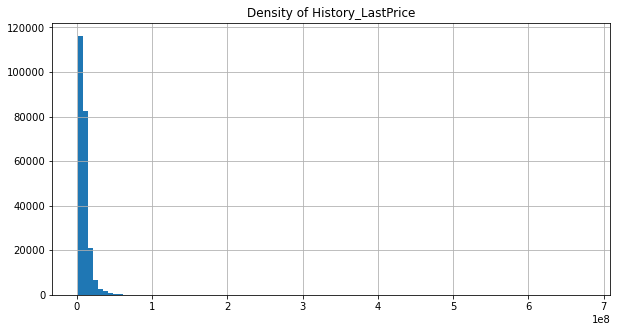

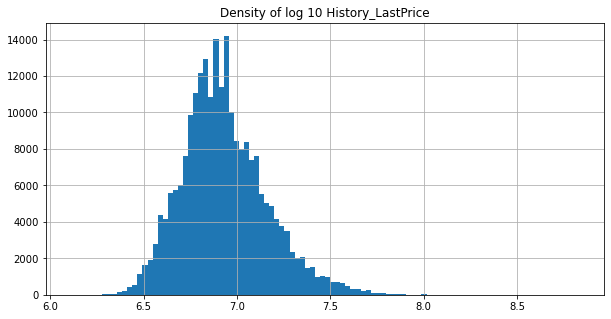

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.grid()
plt.title("Density of History_LastPrice")
_ = plt.hist(res['History_LastPrice'].astype(float), bins=100)
plt.figure(figsize=(10,5))
plt.grid()
plt.title("Density of log 10 History_LastPrice")
_ = plt.hist(np.log10(res['History_LastPrice'].astype(float)), bins=100)

In [5]:
res = res[res['History_LastPrice'] < 100000000].reset_index(drop=True)

In [6]:
res = res.loc[res['Flat_build_year'].astype(float) < 2020]

In [7]:
def preprocess_data(res):
    res['Flat_flat/apart'] = pd.Categorical(res['Flat_flat/apart'])

    res['Flat_build_year'] = res['Flat_build_year'].fillna(res['Flat_build_year'].mode())

    res['Flat_lift'] = res['Flat_lift'].apply(lambda x: 1 if x == 'есть' else 0)

    res['Flat_view'] = pd.Categorical(res['Flat_view'].fillna('unknown'))

    res['Flat_rooms_smeg'] = pd.Categorical(res['Flat_rooms_smeg'].astype(str).fillna("Unknown"))

    res['Flat_station'] = pd.Categorical(res['Flat_station'].astype(str))

    res['Flat_otdelka'] = pd.Categorical(res['Flat_otdelka'], 
                                    categories=['без отд.', 'хор.сост.', 'евр.рем.', 'дизайн.рем.'], 
                                    ordered = True,)

    res['Flat_otdelka'] = res['Flat_otdelka'].fillna('хор.сост.')

    logia_dict = {"Л" : 1, "2Л" : 2, "БЛ" : 1, "3Л" : 3, "Б2Л" : 2, "4Л" : 4, "2Б2Л" : 2, "ЭркЛ" : 1, "*Л" : 1}
    balcony_dict = {"Б" : 1, "2Б" : 2, "БЛ" : 1, "3Б" : 3, "Б2Л" : 1, "3Б" : 3, "2Б2Л" : 2, "*Б" : 1}

    res['Flat_balcony'] = res['Flat_balcon'].map(balcony_dict).fillna(0)
    res['Flat_logia'] = res['Flat_balcon'].map(logia_dict).fillna(0)
    res.drop(columns = ['Flat_balcon'], inplace=True)

    def fillna_minus1(col):
        res[col] = res[col].fillna(-1)

    fillna_minus1('Flat_kitchen_square')
    fillna_minus1('Flat_habitable_square')

    res['Flat_square'] = res['Flat_square'].astype(float)
    res['Flat_kitchen_square'] = res['Flat_kitchen_square'].astype(float)
    res['Flat_habitable_square'] = res['Flat_habitable_square'].astype(float)
    res['Flat_build_year'] = res['Flat_build_year'].astype(float)
    res['Flat_parking'] = pd.Categorical(res['Flat_parking'].astype(str))
    res['Flat_territory_guard'] = pd.Categorical(res['Flat_territory_guard'].astype(str))
    res['Flat_floor'] = res['Flat_floor'].astype(float)
    res['Flat_max_floor'] = res['Flat_max_floor'].astype(float)
    res['Flat_position'] = res['Flat_floor'].astype(float) / res['Flat_max_floor']

    res['GIS_district_Id'] = pd.Categorical(res['GIS_district_Id'])

#     res['Flat_to_station_min_cnt'] = res['Flat_to_station_min_cnt'].astype(float, errors = 'ignore')
#     res['Flat_to_station_min_cnt'] = res['Flat_to_station_min_cnt'].fillna(np.nan)

#     res['Flat_transport_min_metro'] = res['Flat_to_station_min_cnt'].astype(float) * res['Flat_to_station_min_transport'].apply(lambda x: 1 if x == 'т' else 0)
#     res['Flat_by_feet_min_metro'] = res['Flat_to_station_min_cnt'] * res['Flat_to_station_min_transport'].apply(lambda x: 1 if x == 'п' else 0)

#     res['Flat_by_feet_min_metro'] = res['Flat_by_feet_min_metro'].astype(float, errors = 'ignore')
#     res['Flat_by_feet_min_metro'] = res['Flat_by_feet_min_metro'].fillna(np.nan)

#     res.drop(columns = ['Flat_to_station_min_cnt', 'Flat_to_station_min_transport'], inplace=True)

    nonseparated_dict = {'С' : 1, '2С' : 2, "3С" : 3, "4С" : 4}
    separated_dict = {'Р' : 1, '2Р' : 2, "3Р" : 3, "4Р" : 4}
    bathrooms = {"С" :     1, "Р": 1, "2" : 2, "2Р" : 2, "2С" : 2, "3" : 3, "-" : 0, "+" : 1, "3Р" : 3, "3С" : 3, "4" : 4, 
                 "4Р" : 4, "4С" : 4}


    res['Flat_nonseparated_dict'] = res['Flat_sanuzel'].map(balcony_dict).fillna(0)
    res['Flat_separated_dict'] = res['Flat_sanuzel'].map(logia_dict).fillna(0)
    res['Flat_bathrooms'] = res['Flat_sanuzel'].map(bathrooms).fillna(0)

    res.drop(columns = ['Flat_sanuzel'], inplace=True)

    res['Flat_spalen'] = res['Flat_spalen'].astype(float).astype(int)

    def Encode_metro_info(data):
        res.drop(columns = ['GIS_House_metro_km'], inplace=True) 
        res['GIS_Metro_Station_Id'] = pd.Categorical(res['GIS_Metro_Station_Id'])
        res['GIS_Metro_Line_Id'] = pd.Categorical(res['GIS_Metro_Line_Id'])
        return data

    res = Encode_metro_info(res)
    
    for each in usless:
        try:
            res.drop(columns=[each], inplace=True)
        except KeyError:
            pass
    return res

In [8]:
res = preprocess_data(res)

In [9]:
cat_columns = res.select_dtypes(['category']).columns

ids = list(filter(lambda x: '_Id' in x, res.columns))

In [10]:
res[list(set(cat_columns).difference(set(ids)))] = res[list(set(cat_columns).difference(set(ids)))].apply(lambda x: x.cat.codes)

In [45]:
# import json
# with open("SecondaryModel\Gis_district_mapping.json", "w") as f:
#     json.dump({name:code for code, name in zip(res['GIS_district'].cat.codes, res['GIS_district'].cat.categories)}, f)

In [11]:
monotone_dict = {'Flat_spalen' : -1, 
                 'Flat_sale_period' : -1, 
                 'Flat_territory_guard' : 1, 
                 'Flat_square' : 0,
                'GIS_isInMKAD' : 1,
                'Flat_height' : 1}

monotone_constraints = [monotone_dict.get(col, 0) for col in res.columns]

def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_logsmape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    preds = np.power(10, preds)
    labels = np.power(10, train_data.get_label())
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

import lightgbm as lgb
best_params = {
 'subsample_for_bin': 200000,
 'subsample': 0.5,
 #'silent': True,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'random_state': 4545,
 'objective': None,
 'num_leaves': 63,
 'n_jobs': -1,
 'n_estimators': 1000,
 #'monotone_constraints': mon, 
 'min_split_gain': 0.01,
 'min_child_weight': 0.01,
 'min_child_samples': 3,
 #'max_depth': 7,
# 'learning_rate': 0.1,
 'importance_type': 'split',
# 'colsample_bytree': 1.0,
 'boosting_type': 'dart',
#     'monotone_constraints' : monotone_constraints
#'bagging_freq' : 1
}

In [12]:
params = best_params
params.pop('monotone_constraints', None)

In [49]:
# model_sec_rent = lgb.Booster(model_file='SecondaryModel\sec_model_rent.txt')
# model_schema_rent = pd.read_csv("SecondaryModel\modes_rent.csv", index_col=0)
# res['GIS_district'] = res['GIS_district_Id']
# res.rename({"lat": "CoordLat", "lng" : "CoordLng" }, inplace=True)
# res['RentEstimate'] = model_sec_rent.predict(res[model_schema_rent.columns])

C:\Users\rudenkoda\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Best score is 6.711384798457392 on 997 round


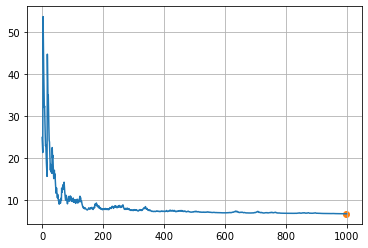

In [51]:
#feature_matrix_filled.columns = [i for i in range(len(feature_matrix_filled.columns))]
cv = lgb.cv(params, train_set=lgb.Dataset(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district']).values, label = res['History_LastPrice']  / res['Flat_square'].values), stratified=False, feval = lgbm_smape, nfold = 7)
plt.plot(cv['SMAPE-mean'])
plt.grid()
plt.fill_between(list(range(params['n_estimators'])), np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']), -np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']),alpha=0.3 )
plt.scatter(np.argmin(cv['SMAPE-mean']), np.min(cv['SMAPE-mean']))
print(f"Best score is {np.min(cv['SMAPE-mean'])} on {np.argmin(cv['SMAPE-mean'])} round")

Best score is 9.209273489795622 on 972 round


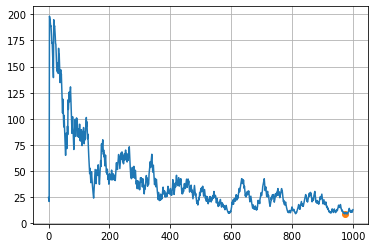

In [52]:
#feature_matrix_filled.columns = [i for i in range(len(feature_matrix_filled.columns))]
cv = lgb.cv(params, train_set=lgb.Dataset(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district']).values, label = np.log10(res['History_LastPrice']  / res['Flat_square'].values)), stratified=False, feval = lgbm_logsmape, nfold = 7)
plt.plot(cv['SMAPE-mean'])
plt.grid()
plt.fill_between(list(range(params['n_estimators'])), np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']), -np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']),alpha=0.3 )
plt.scatter(np.argmin(cv['SMAPE-mean']), np.min(cv['SMAPE-mean']))
print(f"Best score is {np.min(cv['SMAPE-mean'])} on {np.argmin(cv['SMAPE-mean'])} round")

In [15]:
model = lgb.LGBMRegressor(**best_params)

model = model.fit(res[[col for col in res.columns if col in ['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district']]].values, 
                  res['History_LastPrice']  / res['Flat_square'].values)

model.booster_.save_model('SecondaryModel\sec_model_sec.txt')

In [56]:
schema = res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district']).mode().loc[:0]
schema.to_csv("SecondaryModel\modes.csv")

In [57]:
import json
with open("SecondaryModel\model_sec_schema.json", "w") as f:
    json.dump(list(schema.columns), f)

In [59]:
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
params['n_estimators'] = 300

pred_df = res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district']).copy(deep=True).reset_index(drop=True)
predictions = pd.Series(index=pred_df.index, data=0)
y = pd.Series(res['History_LastPrice']  / res['Flat_square'].values).reset_index(drop=True)
sc = pred_df.columns
splits = 10
cv = KFold(n_splits = splits, shuffle = True, random_state= 4545)
for train_idx, test_idx in tqdm_notebook(cv.split(pred_df, y), total = splits):
    model = lgb.LGBMRegressor(**params)
    model = model.fit(pred_df.loc[train_idx].values, y.reset_index(drop=True).loc[train_idx])
    preds = model.predict(pred_df.loc[test_idx])
    predictions.loc[test_idx] = preds
    
smape(y, predictions)

C:\Users\rudenkoda\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


7.954818581921569

In [60]:
pred_df['Price'] = predictions

pred_df['History_LastPrice'] = res['History_LastPrice'].values

pred_df['Flat_CianId'] = res['Flat_CianId'].values
row = DataLoader().outload_score(pred_df, predictions)

In [61]:
smape(y, predictions)

7.954818581921569

In [62]:
smape(y, predictions)

7.954818581921569

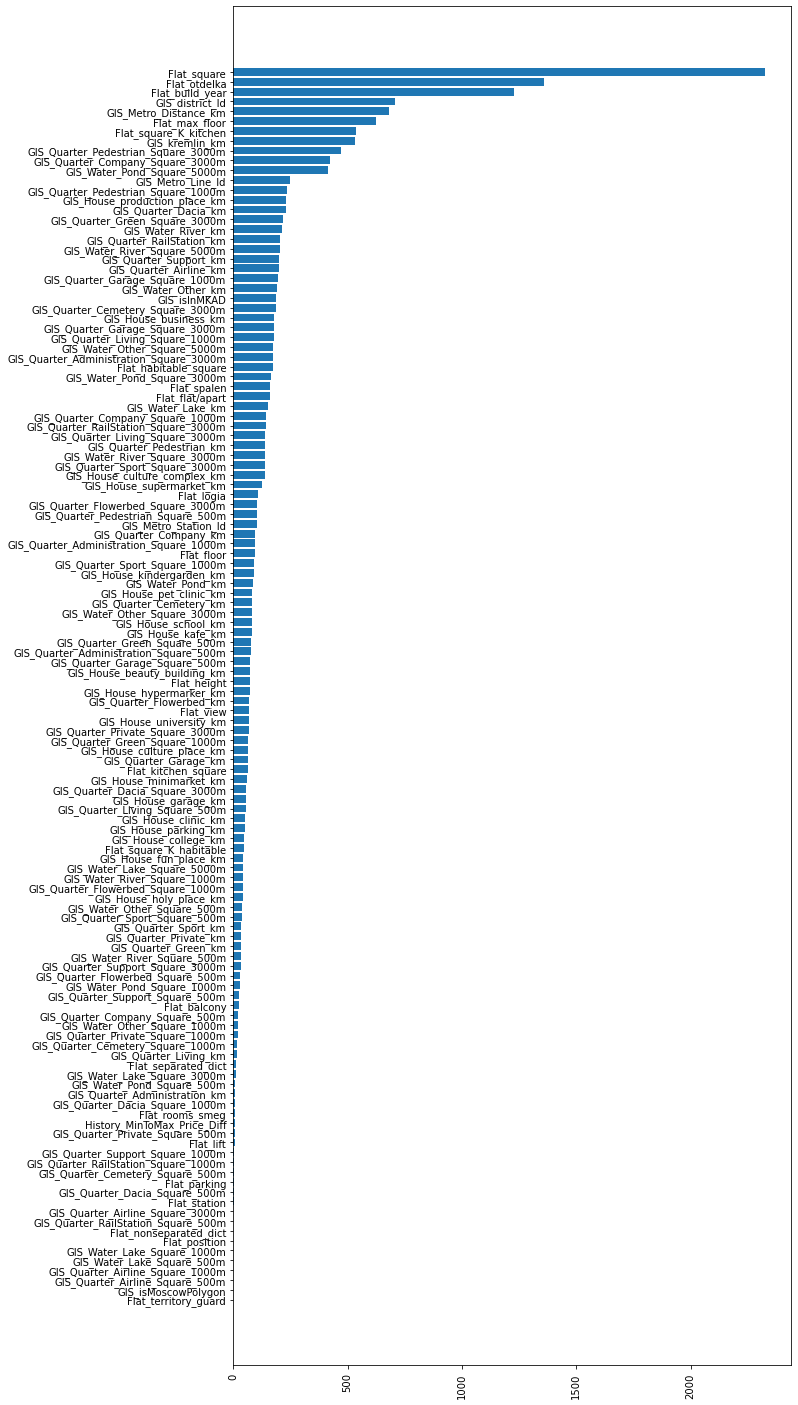

In [63]:
cl, names = zip(*sorted(zip(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).columns, model.feature_importances_), key  =lambda x: x[1]))
plt.figure(figsize=(10,25))
_ = plt.barh(cl, names, )
_ = plt.xticks(rotation=90)

Text(0.5, 1.0, '95% Confidence interval is 0.21085189406549726')

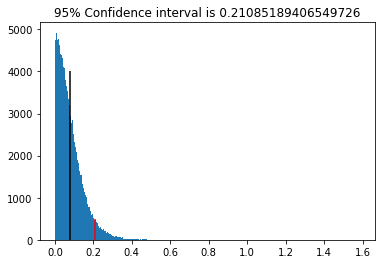

In [64]:
vvv = 2 * np.abs(pred_df['Price'] - pred_df['History_LastPrice'] / pred_df['Flat_square']) / np.abs(pred_df['Price'] + pred_df['History_LastPrice']/ pred_df['Flat_square'])
_ = plt.hist(vvv, bins = 500)
plt.vlines(np.mean(vvv), ymin=0, ymax=4000)
plt.vlines(np.percentile(vvv, q=95), ymin=0, ymax=500, color='red')
plt.title(f"95% Confidence interval is {np.percentile(vvv, q=95)}")

In [65]:
res['Price'] = np.round(predictions, decimals=-2).astype(float)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.600e+01, 2.100e+01, 4.000e+01, 1.030e+02,
        1.210e+02, 1.840e+02, 2.490e+02, 3.710e+02, 4.310e+02, 6.140e+02,
        7.770e+02, 9.740e+02, 1.275e+03, 1.423e+03, 1.631e+03, 2.006e+03,
        2.310e+03, 2.730e+03, 2.746e+03, 2.800e+03, 2.947e+03, 3.014e+03,
        2.978e+03, 3.249e+03, 3.379e+03, 3.289e+03, 3.211e+03, 3.262e+03,
        3.147e+03, 3.135e+03, 3.120e+03, 2.907e+03, 2.934e+03, 2.959e+03,
        2.778e+03, 2.825e+03, 2.990e+03, 2.833e+03, 3.227e+03, 3.058e+03,
        3.048e+03, 3.301e+03, 3.612e+03, 2.544e+03, 3.324e+03, 2.727e+03,
        3.365e+03, 3.149e+03, 3.177e+03, 3.013e+03, 2.870e+03, 2.884e+03,
        2.800e+03, 2.423e+03, 2.388e+03, 2.584e+03, 2.378e+03, 2.211e+03,
        2.105e+03, 2.073e+03, 1.915e+03, 1.910e+03, 1.656e+03, 1.638e+03,
        1.498e+03, 1.566e+03, 1.497e+03, 1.364e+03, 1.338e+03, 1.312e+03,
        1.267e+03, 1.202e+03, 9.430e+0

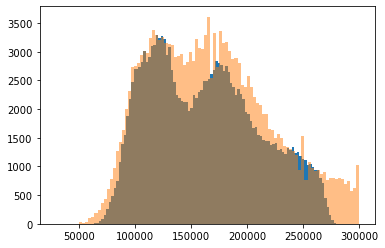

In [66]:
plt.hist(np.round(predictions, decimals=-2), bins=100)
plt.hist(np.round(y), bins=100, alpha=0.5)

In [92]:
import shap
idx = 91527
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(res.drop(columns=['History_LastPrice']).loc[idx:idx].astype(float))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAPError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [63]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

shap.force_plot(explainer.expected_value, shap_values[0,:], res.drop(columns=['History_LastPrice']).loc[idx:idx].astype(float))

NameError: name 'shap' is not defined

In [67]:
heatmap = DataLoader().load_heatmap()

In [68]:
heatmap = preprocess_data(heatmap)

In [71]:
heatmap_pred = model.predict(heatmap[res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat', 
                                                            'History_MinToMax_Price_Diff', 'GIS_district', 'Price']).columns])

In [72]:
DataLoader().outload_heatmap(heatmap, heatmap_pred)

In [ ]:
55.8018989562988    37.4930000305176

In [38]:
temp_h = heatmap[(np.abs(heatmap.Flat_CoordLat - 55.801899) < 0.00001) & (np.abs(heatmap.Flat_CoordLng - 37.493000) < 0.00001)]

In [39]:
temp_h

Flat_CianId  History_LastPrice  Flat_CoordLat  Flat_CoordLng  \
20517    224332902          6500000.0      55.801899         37.493   

       Flat_spalen   Flat_station  Flat_square  Flat_kitchen_square  \
20517            2  Некрасовка м.         38.0                 10.0   

       Flat_habitable_square  Flat_square_K_habitable  ...  Flat_balcony  \
20517                   19.0                      0.5  ...           0.0   

      Flat_logia  Flat_position  Flat_transport_min_metro  \
20517          1       0.117647                       0.0   

      Flat_by_feet_min_metro Flat_nonseparated_dict Flat_separated_dict  \
20517                   15.0                    0.0                 0.0   

      Flat_bathrooms          Price        Date  
20517              1  240753.306192  2020-04-08  

[1 rows x 134 columns]

In [37]:
temp  = res[(np.abs(res.Flat_CoordLat - 55.801899) < 0.00001) & (np.abs(res.Flat_CoordLng - 37.493000) < 0.00001)]
temp['History_LastPrice'] / temp['Flat_square']

108668    188095.214286
108669    181395.348837
108670    204545.454545
136628    179522.727273
136633    180681.818182
136634    180681.818182
136635    171717.391304
dtype: float64

In [43]:
temp.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat'])

Flat_spalen  Flat_station  Flat_square  Flat_kitchen_square  \
108668            2           161         42.0                  6.0   
108669            2           291         43.0                  6.0   
108670            2           161         44.0                  6.0   
136628            2           170         44.0                  6.0   
136633            2           161         44.0                  7.0   
136634            2           161         44.0                  7.0   
136635            2           161         46.0                  7.0   

        Flat_habitable_square  Flat_square_K_habitable  Flat_square_K_kitchen  \
108668                   27.0                 0.642857               0.142857   
108669                   31.0                 0.720930               0.139535   
108670                   34.0                 0.772727               0.136364   
136628                   30.0                 0.681818               0.136364   
136633                   29.0                 0.659091               0.159091   
136634                   29.0                 0.659091               0.159091   
136635                   32.0                 0.695652               0.152174   

        Flat_rooms_smeg  Flat_build_year  Flat_lift  ...  GIS_Metro_Line_Id  \
108668                1           1962.0          0  ...                NaN   
108669                1           1962.0          0  ...                NaN   
108670                2           1962.0          0  ...                NaN   
136628                1           1962.0          0  ...                NaN   
136633                0           1962.0          0  ...                NaN   
136634                0           1962.0          0  ...                NaN   
136635                1           1962.0          0  ...                NaN   

        GIS_district_Id  Flat_balcony  Flat_logia  Flat_position  \
108668              NaN           1.0         0.0            0.4   
108669              NaN           1.0         0.0            0.4   
108670              NaN           1.0         0.0            0.8   
136628              NaN           1.0         0.0            0.4   
136633              NaN           1.0         0.0            1.0   
136634              NaN           1.0         0.0            1.0   
136635              NaN           1.0         0.0            0.4   

        Flat_transport_min_metro  Flat_by_feet_min_metro  \
108668                       0.0                    13.0   
108669                       4.0                     0.0   
108670                       0.0                    15.0   
136628                       0.0                    10.0   
136633                       1.0                     0.0   
136634                       1.0                     0.0   
136635                       0.0                    10.0   

        Flat_nonseparated_dict  Flat_separated_dict  Flat_bathrooms  
108668                     0.0                  0.0             1.0  
108669                     0.0                  0.0             1.0  
108670                     0.0                  0.0             1.0  
136628                     0.0                  0.0             1.0  
136633                     0.0                  0.0             1.0  
136634                     0.0                  0.0             1.0  
136635                     0.0                  0.0             1.0  

[7 rows x 128 columns]

In [47]:
temp_h[temp.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).columns].to_csv("some_shit_delete_it.csv")

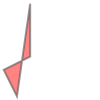

In [1]:
from shapely.geometry import Polygon, Point

x = [3,4,5,5,3]
y = [3,1,8,4,3]
extra_points = [Point(1, 1), Point(2, 2), Point(4, 4)]
some_poly = Polygon(zip(x,y))
some_poly

In [2]:
def add_points(poly, points):
    point_x, point_y = list(zip(*map(lambda p: (p.xy[0][0], p.xy[0][0]), points)))
    x, y = some_poly.exterior.coords.xy
    x, y = x.tolist() + list(point_x), y.tolist() + list(point_y)
    coords = (x,y)
    return Polygon(list(zip(*(x,y))))

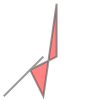

In [3]:
result = add_points(some_poly, extra_points)
result

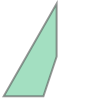

In [4]:
add_points(some_poly, [Point(1, 1), Point(2, 2), Point(4, 4)]).convex_hull

In [69]:
list(zip(*map(lambda p: (p.xy[0][0], p.xy[0][0]), [Point(1, 1), Point(2, 2), Point(4, 4)])))

[(1.0, 2.0, 4.0), (1.0, 2.0, 4.0)]

In [70]:
x, y= list(zip(*map(lambda p: (p.xy[0][0], p.xy[0][0]), [Point(1, 1), Point(2, 2), Point(4, 4)])))

In [77]:
*x, *y

(1.0, 2.0, 4.0, 1.0, 2.0, 4.0)

In [40]:
px = list(map(lambda x: x.xy, [Point(1,1)]))

In [47]:
px[0][0].tolist()

[1.0]

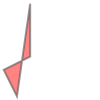

In [30]:
x, y = some_poly.exterior.coords.xy

In [32]:
x.tolist()

[3.0, 4.0, 5.0, 5.0, 3.0]

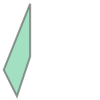

In [29]:
some_poly.convex_hull